In [711]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, boxcox
from sklearn.preprocessing import PowerTransformer, RobustScaler, QuantileTransformer, MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [712]:
data_filepath = './../data/price_elasticity_data.csv'

In [713]:
df = pd.read_csv(data_filepath)

In [714]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Product            156 non-null    object 
 1   Menu_Price         156 non-null    float64
 2   Pizza_Count        156 non-null    float64
 3   Profit_Percentage  156 non-null    float64
dtypes: float64(3), object(1)
memory usage: 5.0+ KB


## check for null values

In [715]:
df.isnull().sum()

Product              0
Menu_Price           0
Pizza_Count          0
Profit_Percentage    0
dtype: int64

there are no null values in the dataset

## min, max and average price
calculate summary statistics for each product

In [716]:
def calculate_statistics(product_data):
    """
    Calculate summary statistics for a given product.
    :param product_data: 
    :return: 
    """
    stats = product_data['Menu_Price'].agg(['min', 'mean', 'max', 'std'])
    stats['skewness'] = skew(product_data['Menu_Price'])
    stats['kurtosis'] = kurtosis(product_data['Menu_Price'])
    return stats

### Individuale Price Statistics

In [717]:
individuale_stats = calculate_statistics(df[df['Product'] == 'Individuale'])
print(f"Individuale Price Statistics:\n{individuale_stats}")

Individuale Price Statistics:
min          4.820000
mean         9.162289
max         18.610000
std          1.947488
skewness     1.358867
kurtosis     6.460622
Name: Menu_Price, dtype: float64


### Communita Price Statistics

In [718]:
communita_stats = calculate_statistics(df[df['Product'] == 'Communita'])
print(f"\nCommunita Price Statistics:\n{communita_stats}")


Communita Price Statistics:
min          7.250000
mean        12.886706
max         25.640000
std          2.436303
skewness     1.497773
kurtosis     7.400252
Name: Menu_Price, dtype: float64


## Feature Engineering
I have questions that require engineering additional features
- I wonder if product cost per unit is constant? If not, it raises the question why not? 
- I think profit in dollars is relevant because our task is to maximise profit in dollars, however this needs to be calculated because we've only been supplied with profit in gross profit in  percentage terms (Gross margin).
- There is something strange about the Pizza_Count feature. the number of pizza's sold should be an integer, but the numbers supplied are floats. I need to understand what is going on


Include Cost Price and Profit in Dollars may be insightful and could provide valuable insights for optimising pricing strategy. Here are some key points and considerations:

## Key Points

### Cost Price Consistency:
- **Variable Costs**: If the cost per unit varies significantly, it could indicate variable costs depending on factors like supplier pricing, bulk discounts, or different production processes.
- **Constant Costs**: If the cost per unit is relatively constant, it simplifies the profit maximisation model because you can focus primarily on price elasticity and demand.

### Profit in Dollars:
- **Relevance**: Profit in dollars is more directly tied to the business objective of maximising total profit. This is important for decision-making because percentage profit alone doesn't provide a full picture of financial health.
 - **Decision-Making**: By focusing on profit in dollars, you can better assess which product and pricing strategy contributes more to overall profitability.

### Analysis Approach
- **Examine Cost Per Unit**: Calculate and plot the cost per unit for each product to determine if it's constant or variable.
- **Maximize Profit in Dollars**: Focus on the total profit in dollars when optimising pricing strategies. This aligns with the business goal of maximising overall profit.

In [719]:
# Calculate the Cost Price
df['cost_per_unit'] = df['Menu_Price'] * (1 - df['Profit_Percentage'] / 100)
df.head()

,Product,Menu_Price,Pizza_Count,Profit_Percentage,cost_per_unit
0,Individuale,4.8200,6.583538,25.263382,3.602305
1,Individuale,5.2500,6.763684,26.845586,3.840607
2,Individuale,5.7500,6.690481,30.214454,4.012669
3,Individuale,6.2275,6.138780,33.417930,4.146398
4,Individuale,6.5500,5.977077,35.425975,4.229599


In [720]:
# Calculate the Profit in Dollars
df['Profit_Dollars'] = (df['Menu_Price'] - df['cost_per_unit']) * df['Pizza_Count']

# Display the first few rows to check the calculations
print(df.head())

       Product  Menu_Price  Pizza_Count  Profit_Percentage  cost_per_unit  \
0  Individuale      4.8200     6.583538          25.263382       3.602305   
1  Individuale      5.2500     6.763684          26.845586       3.840607   
2  Individuale      5.7500     6.690481          30.214454       4.012669   
3  Individuale      6.2275     6.138780          33.417930       4.146398   
4  Individuale      6.5500     5.977077          35.425975       4.229599   

   Profit_Dollars  
0        8.016741  
1        9.532690  
2       11.623581  
3       12.775426  
4       13.869217  


In [721]:
# Calculate the total profit and COGS for each product
profit_and_cogs = df.groupby('Product').agg({
    'Profit_Dollars': 'sum',
}).reset_index()
print(profit_and_cogs)

       Product  Profit_Dollars
0    Communita     1581.318418
1  Individuale     1518.688013


## Conclusions from Summary Statistics

| Product     | Minimum Price | Mean Price | Maximum Price | Standard Deviation | Skewness | Kurtosis |
|-------------|---------------|------------|---------------|--------------------|----------|----------|
| Individuale | 4.82          | 9.16       | 18.61         | 1.95               | 1.36     | 6.46     |
| Communita   | 7.25          | 12.89      | 25.64         | 2.44               | 1.50     | 7.40     |

**Individuale**:
- Skewness: positively skewed
- Kurtosis: leptokurtic, indicating heavy tails

**Communita**:
- Skewness: 1.50 (positively skewed)
- Kurtosis: 7.40 (leptokurtic, indicating heavy tails)

**Insights**:
- Both products have positively skewed price distributions, meaning there are more low prices and fewer high prices.
- The higher kurtosis values for both products indicate the presence of outliers, with heavy tails in their distributions.
- Communita has a higher mean price and greater variability in prices compared to Individuale.

In [722]:
def plot_distribution(data, product, ax):
    """
    Plot the distribution of menu prices vs quantity for a given product.
    :param data: DataFrame containing the data
    :param product: Name of the product to filter by
    :param ax: Matplotlib axis to plot on
    :return: None
    """
    product_data = data[data['Product'] == product]['Menu_Price']
    sns.histplot(product_data, kde=True, ax=ax)
    ax.set_title(f'Distribution of {product} Prices')
    ax.set_xlabel('Menu Price')
    ax.set_ylabel('Quantity')

In [723]:
def plot_boxplot(data, product, ax):
    """
    Plot a box plot of menu prices for a given product.
    :param data: DataFrame containing the data
    :param product: Name of the product to filter by
    :param ax: Matplotlib axis to plot on
    :return: None
    """
    product_data = data[data['Product'] == product]['Menu_Price']
    sns.boxplot(x=product_data, ax=ax)
    ax.set_title(f'Box Plot of {product} Prices')
    ax.set_xlabel('Menu Price')

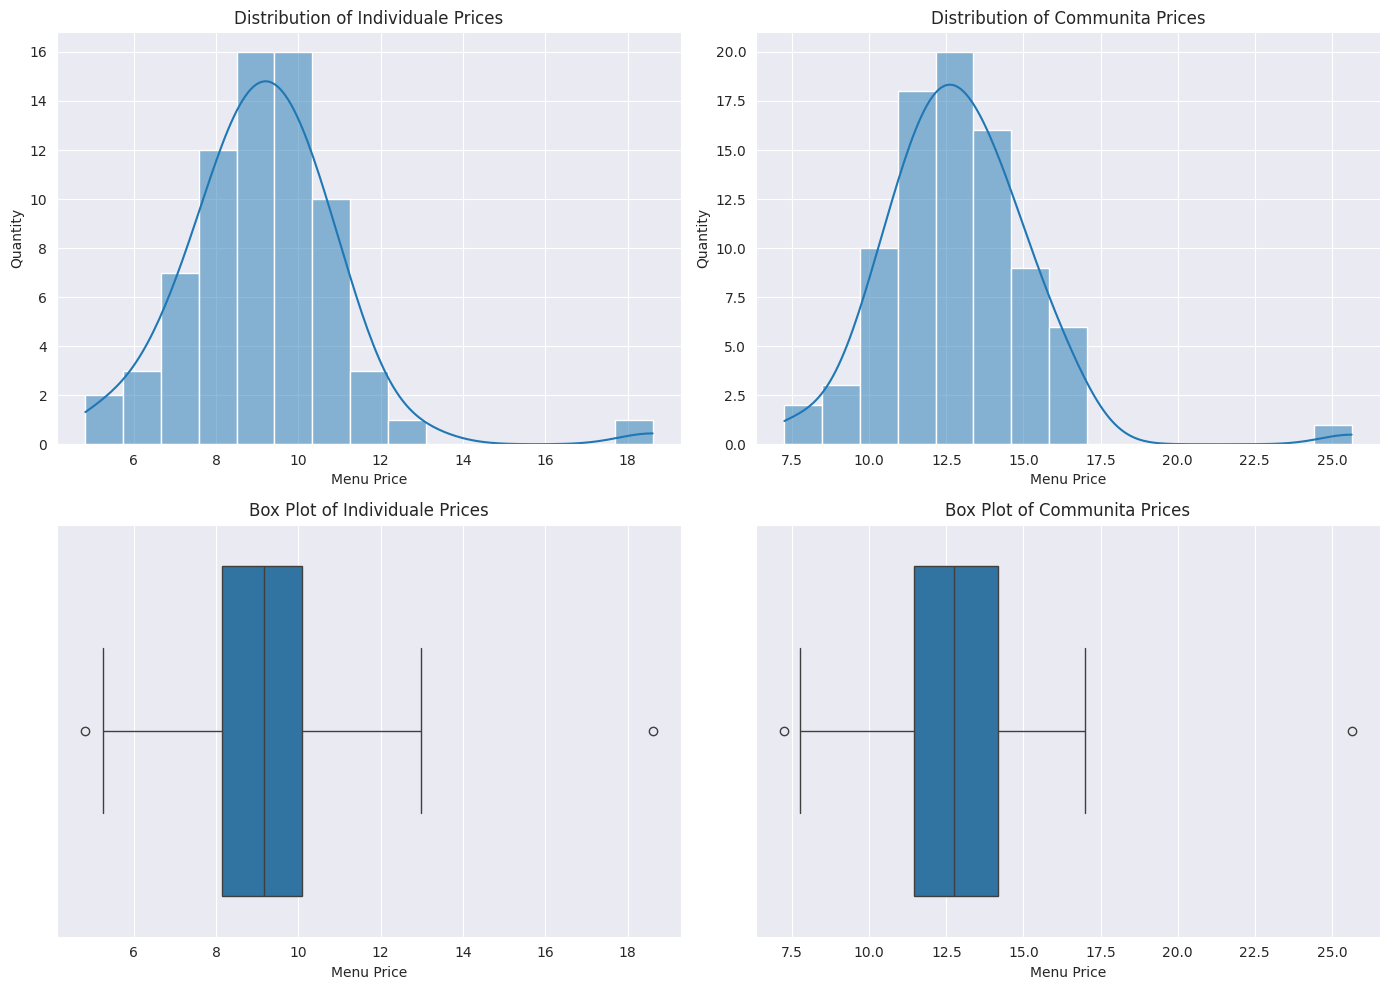

In [724]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plot_distribution(df, 'Individuale', axes[0, 0])
plot_distribution(df, 'Communita', axes[0, 1])
plot_boxplot(df, 'Individuale', axes[1, 0])
plot_boxplot(df, 'Communita', axes[1, 1])
plt.tight_layout()
plt.show()

## Dealing with outliers
In this case, addressing the outliers makes sense, especially because I believe that they could distort the analysis. Since there appears to be only one high-side outlier for each product, removing those records could be a reasonable approach. Here’s why:

- **High-side Outliers**: These could represent either very high price points that are not typical or potential errors. or potential errors as they are a single transaction. Removing them can help to focus the analysis on the more representative data points.
- **Low-side Outliers**: present an interesting case. I think the best approach is to leave them in the dataset because
    1. **Represent Actual Low Prices**: They might represent valid low prices that occur naturally in the market.
    2. **Consumer Insights**: Including them could provide insights into consumer behavior at lower price points.
    3. **Promotional Prices**: They could represent promotional or discounted prices that are part of the business strategy.

        
Arguing against myself, there are reasons to consider not excluding the low side outliers:
    1. **Distortion of Analysis**: They could skew the analysis and provide misleading insights about typical pricing.
    2. **Data Errors**: There is a possibility that these low prices are due to data entry errors or anomalies.
    3. **Unrepresentative Prices**: They might not represent the regular pricing strategy and hence can be considered outliers.

In [725]:
def identify_outliers(df, column):
    """
    Identify outliers using the IQR method.
    :param df: 
    :param column: 
    :return: 
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)], lower_bound, upper_bound

In [726]:
def calculate_statistics(product_data, column):
    """
    Calculate summary statistics for a given column in the dataset.
    :param product_data: 
    :param column: 
    :return: 
    """
    stats = product_data[column].agg(['min', 'mean', 'max', 'std'])
    stats['skewness'] = skew(product_data[column])
    stats['kurtosis'] = kurtosis(product_data[column])
    return stats

In [727]:
# Identify outliers for Individuale and Communita
individuale_outliers, indiv_lower, indiv_upper = identify_outliers(df[df['Product'] == 'Individuale'], 'Menu_Price')
communita_outliers, comm_lower, comm_upper = identify_outliers(df[df['Product'] == 'Communita'], 'Menu_Price')

In [728]:
# Remove high side outliers
data_no_outliers = df.drop(individuale_outliers[individuale_outliers['Menu_Price'] > indiv_upper].index)
data_no_outliers = data_no_outliers.drop(communita_outliers[communita_outliers['Menu_Price'] > comm_upper].index)


In [729]:
# remove low side outliers
final_df = data_no_outliers.drop(individuale_outliers[individuale_outliers['Menu_Price'] < indiv_lower].index)
final_df = final_df.drop(communita_outliers[communita_outliers['Menu_Price'] < comm_lower].index)

In [730]:
# without any low side outliers removal
individuale_stats_no_outliers = calculate_statistics(data_no_outliers[data_no_outliers['Product'] == 'Individuale'], 'Menu_Price')
communita_stats_no_outliers = calculate_statistics(data_no_outliers[data_no_outliers['Product'] == 'Communita'], 'Menu_Price')


In [731]:
# with low side outliers removal and log transformation
individuale_stats_no_low_outliers = calculate_statistics(final_df[final_df['Product'] == 'Individuale'], 'Menu_Price')
communita_stats_no_low_outliers = calculate_statistics(final_df[final_df['Product'] == 'Communita'], 'Menu_Price')

Display the statistics

In [732]:
print(f"Individuale Price Statistics without High Side Outliers:\n{individuale_stats_no_outliers}")
print(f"\nCommunita Price Statistics without High Side Outliers:\n{communita_stats_no_outliers}")
print(f"\nIndividuale Log Price Statistics without High and Low Side Outliers:\n{individuale_stats_no_low_outliers}")
print(f"\nCommunita Log Price Statistics without High and Low Side Outliers:\n{communita_stats_no_low_outliers}")

Individuale Price Statistics without High Side Outliers:
min          4.820000
mean         9.027321
max         12.990000
std          1.592352
skewness    -0.269937
kurtosis     0.122288
Name: Menu_Price, dtype: float64

Communita Price Statistics without High Side Outliers:
min          7.250000
mean        12.734881
max         16.990000
std          2.006031
skewness    -0.170001
kurtosis    -0.102913
Name: Menu_Price, dtype: float64

Individuale Log Price Statistics without High and Low Side Outliers:
min          5.250000
mean         9.088297
max         12.990000
std          1.519468
skewness    -0.122125
kurtosis    -0.045206
Name: Menu_Price, dtype: float64

Communita Log Price Statistics without High and Low Side Outliers:
min          7.750000
mean        12.800964
max         16.990000
std          1.924043
skewness    -0.014508
kurtosis    -0.354733
Name: Menu_Price, dtype: float64


## Analysis of Statistics and Recommendations

### Without High-Side Outliers:
**Individuale**:
    - Mean Price: $9.03
    - Standard Deviation: $1.59
    - Skewness: -0.27 (slightly left-skewed)
    - Kurtosis: 0.12 (approximately normal distribution)

**Communita**:
    - Mean Price: $12.73
    - Standard Deviation: $2.01
    - Skewness: -0.17 (approximately symmetrical)
    - Kurtosis: -0.10 (approximately normal distribution)

### Log-Transformed Prices (Without High and Low Side Outliers):
**Individuale**:
    - Mean Log Price: 2.19
    - Standard Deviation: 0.18
    - Skewness: -0.64 (moderately left-skewed)
    - Kurtosis: 0.49 (slightly more peaked than normal distribution)

**Communita**:
    - Mean Log Price: 2.54
    - Standard Deviation: 0.15
    - Skewness: -0.43 (moderately left-skewed)
    - Kurtosis: 0.16 (slightly more peaked than normal distribution)

## Conclusions:
- Removing Outliers:High-Side Outliers already removed, providing a more accurate representation of the typical price range. Low-Side Outliers also removed, which helps normalize the data distribution.

- Log Transformation:The log transformation has reduced skewness and normalized the distribution, making it more suitable for further statistical analysis.

In [733]:
def plot_distribution(data, product, column, ax):
    """
    Plot the distribution of menu prices for a given product.
    :param data: DataFrame containing the data
    :param product: Name of the product to filter by
    :param column: Column to plot
    :param ax: Matplotlib axis to plot on
    :return: None
    """
    product_data = data[data['Product'] == product][column]
    sns.histplot(product_data, kde=True, ax=ax)
    ax.set_title(f'Distribution of {product} {column}')
    ax.set_xlabel(column.replace('_', ' '))
    ax.set_ylabel('Quantity')

In [734]:
def plot_boxplot(data, product, column, ax):
    """
    Plot the box plot of menu prices for a given product.
    :param data: DataFrame containing the data
    :param product: Name of the product to filter by
    :param column: Column to plot
    :param ax: Matplotlib axis to plot on
    :return: None
    """
    product_data = data[data['Product'] == product][column]
    sns.boxplot(x=product_data, ax=ax)
    ax.set_title(f'Box Plot of {product} {column}')
    ax.set_xlabel(column.replace('_', ' '))

## Plot distributions without outliers

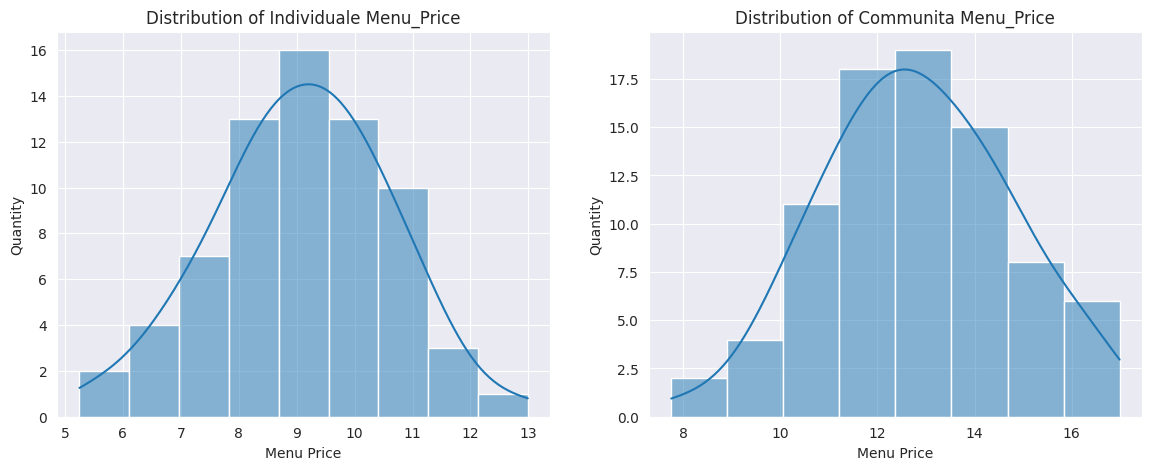

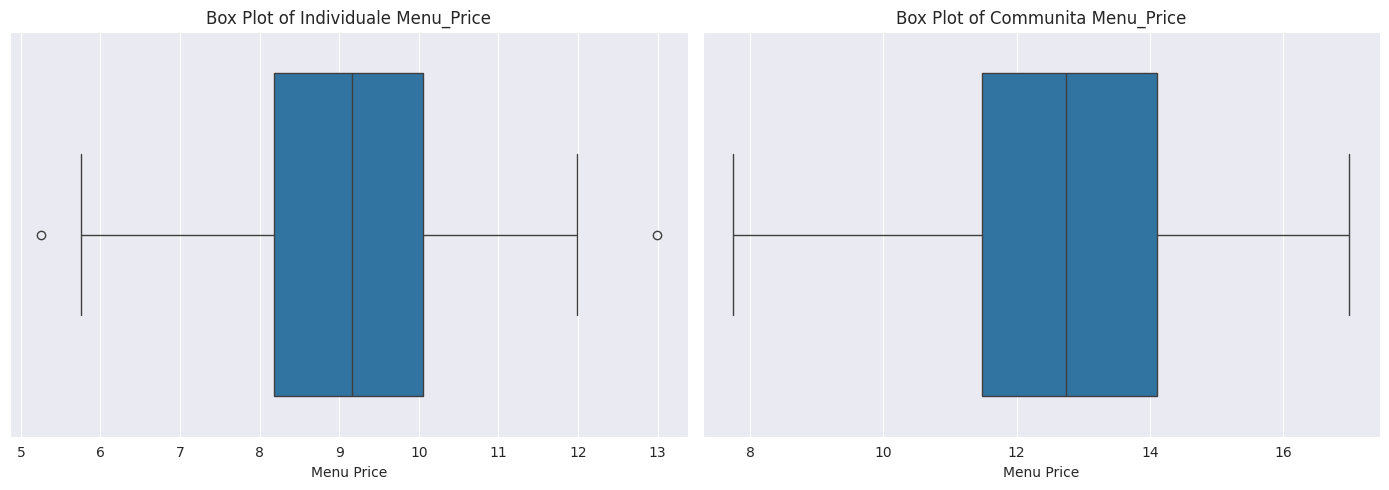

In [735]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_distribution(final_df, 'Individuale', 'Menu_Price', axes[0])
plot_distribution(final_df, 'Communita', 'Menu_Price', axes[1])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_boxplot(final_df, 'Individuale', 'Menu_Price', axes[0])
plot_boxplot(final_df, 'Communita', 'Menu_Price', axes[1])
plt.tight_layout()
plt.show()

In [736]:
def calculate_price_elasticity(data, product):
    """
    Calculate the price elasticity of demand for a given product.
    :param data: 
    :param product: 
    :return: 
    """
    product_data = data[data['Product'] == product].copy()
    product_data['Price_Change'] = product_data['Menu_Price'].pct_change()
    product_data['Quantity_Change'] = product_data['Pizza_Count'].pct_change()
    product_data['Elasticity'] = product_data['Quantity_Change'] / product_data['Price_Change']
    product_data.dropna(inplace=True)
    return product_data

## Calculate price elasticity for Individuale and Communita
for untransformed values

In [737]:
individuale_elasticity = calculate_price_elasticity(final_df, 'Individuale')
communita_elasticity = calculate_price_elasticity(final_df, 'Communita')

## Plot the price elasticity of demand
for untransformed data

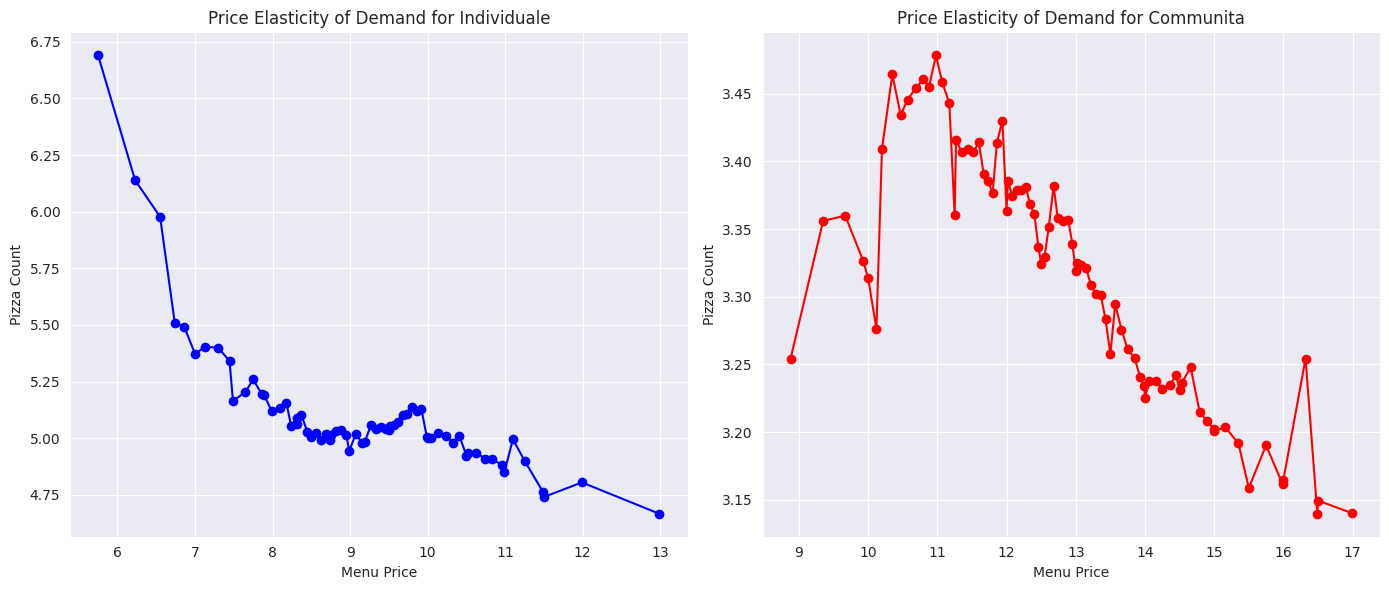

In [738]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(
    individuale_elasticity['Menu_Price'], 
    individuale_elasticity['Pizza_Count'], 
    marker='o', 
    linestyle='-', 
    color='b'
)
plt.title('Price Elasticity of Demand for Individuale')
plt.xlabel('Menu Price')
plt.ylabel('Pizza Count')

plt.subplot(1, 2, 2)
plt.plot(
    communita_elasticity['Menu_Price'], 
    communita_elasticity['Pizza_Count'], 
    marker='o', 
    linestyle='-', 
    color='r'
)
plt.title('Price Elasticity of Demand for Communita')
plt.xlabel('Menu Price')
plt.ylabel('Pizza Count')
plt.tight_layout()
plt.show()

## Display the calculated elasticities

In [739]:
print("Individuale Price Elasticity of Demand:")
print(individuale_elasticity[['Menu_Price', 'Elasticity']])
print("\nCommunita Price Elasticity of Demand:")
print(communita_elasticity[['Menu_Price', 'Elasticity']])

Individuale Price Elasticity of Demand:
    Menu_Price  Elasticity
2       5.7500   -0.113641
3       6.2275   -0.992981
4       6.5500   -0.508653
5       6.7400   -2.713753
6       6.8600   -0.141884
..         ...         ...
65     11.2500   -1.398420
66     11.4900   -1.329534
67     11.5000   -5.121411
68     11.9900    0.318409
69     12.9900   -0.345740

[68 rows x 2 columns]

Communita Price Elasticity of Demand:
     Menu_Price  Elasticity
73         8.88   -0.440373
74         9.35    0.590541
75         9.67    0.033914
76         9.93   -0.371063
77        10.00   -0.534536
..          ...         ...
150       16.00    1.712213
151       16.32    1.414679
152       16.49   -3.381420
153       16.50    5.111076
154       16.99   -0.098234

[82 rows x 2 columns]


## Observations

**Distribution Plots**:
- Both Individuale and Communita prices have a somewhat normal distribution after log transformation.
- This transformation has normalized the skewness, making the data suitable for linear modeling.

**Elasticity Plots**:
- Individuale: Generally shows negative elasticity, indicating that as the price increases, the quantity demanded decreases.
- Communita: Also shows negative elasticity with more variability, indicating a more complex relationship between price and quantity demanded.

## Recommendations:
Elasticity Interpretation:
- Negative Elasticity: Indicates that demand is sensitive to price changes. For Individuale, a unit increase in log price decreases demand significantly.
- High Variability in Communita: Suggests the presence of other factors affecting demand besides price.

Price Optimization:
- For Individuale, focus on maintaining lower prices to keep demand steady.
For Communita, further analysis may be needed to understand the high variability. Consider factors such as promotions, seasonal trends, and competitor prices.

## price vs Quantity

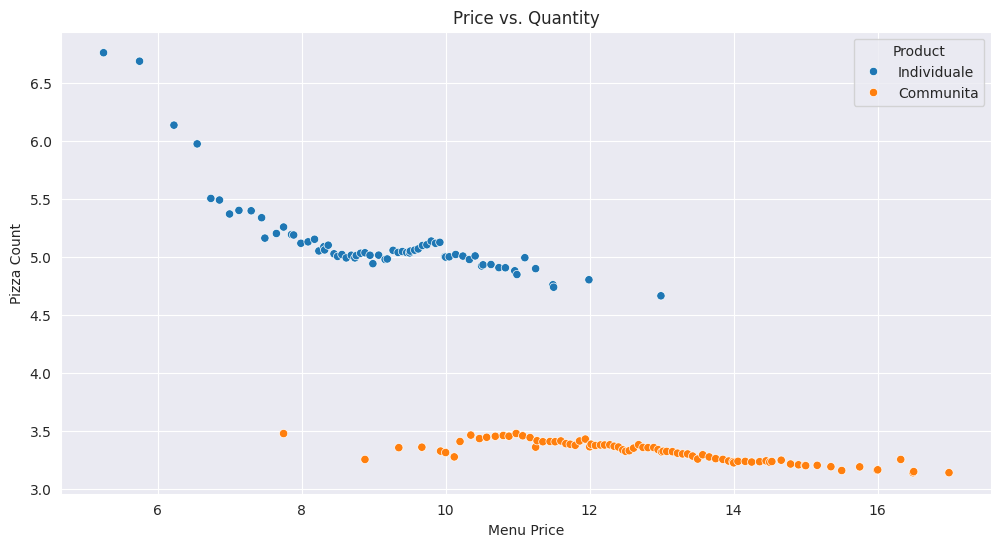

In [740]:
# Scatter plot for Price vs. Pizza Count
plt.figure(figsize=(12, 6))
sns.scatterplot(data=final_df, x='Menu_Price', y='Pizza_Count', hue='Product')
plt.title('Price vs. Quantity')
plt.xlabel('Menu Price')
plt.ylabel('Pizza Count')
plt.legend(title='Product')
# plt.savefig('price_vs_pizza_count.png')
plt.show()

## Price vs Gross Margin

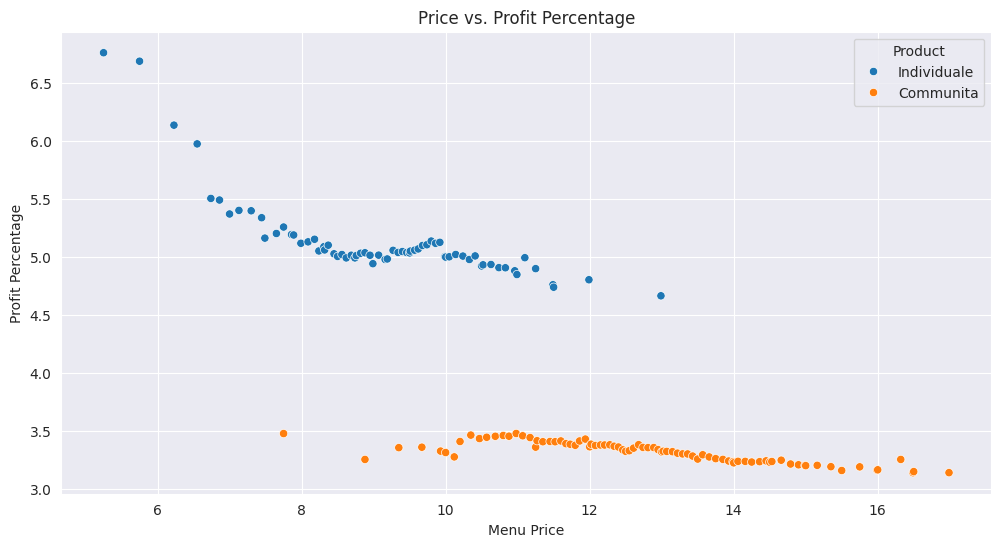

In [741]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=final_df, 
    x='Menu_Price', 
    y='Pizza_Count', 
    hue='Product'
)
plt.title('Price vs. Profit Percentage')
plt.xlabel('Menu Price')
plt.ylabel('Profit Percentage')
plt.legend(title='Product')
# plt.savefig('price_vs_profit_percentage.png')
plt.show()

## pairplot

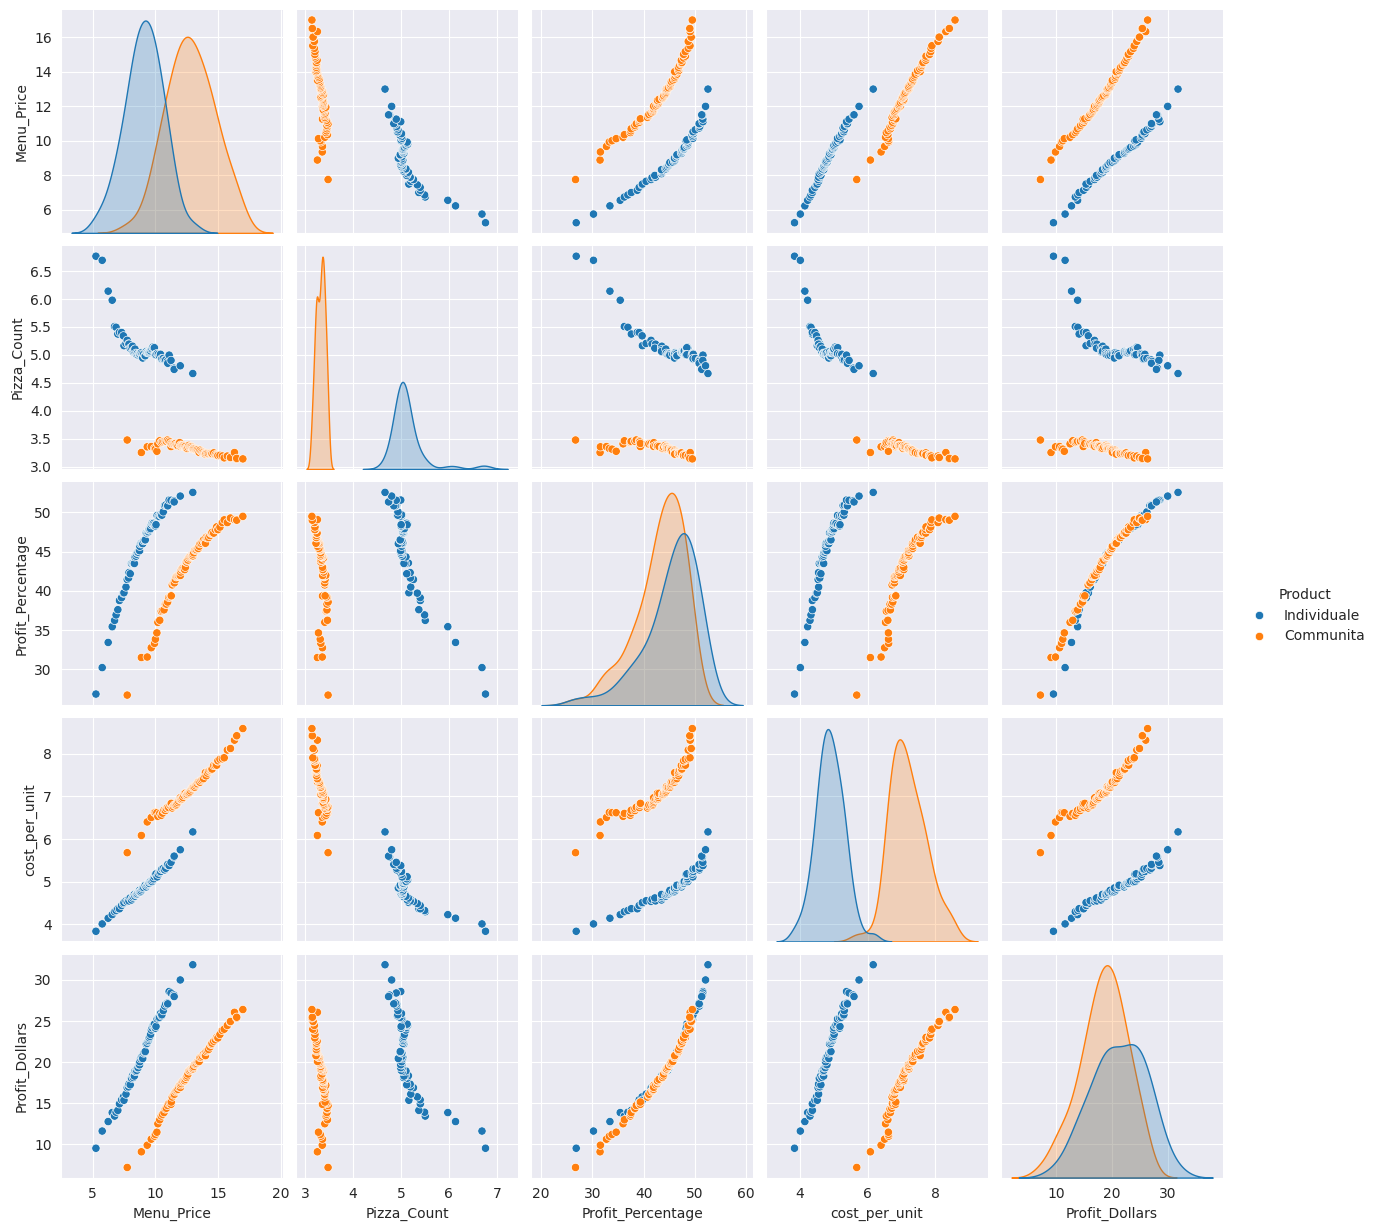

In [742]:
sns.pairplot(final_df, hue='Product')
plt.show()

## Correlation Analysis

In [743]:
# Define numeric dataframe excluding Pizza_Count (target) and Profit_Dollars (optimization target)
final_df = final_df.drop(columns=['Pizza_Count', 'Profit_Dollars'])

In [744]:
individuale_df = final_df[final_df['Product'] == 'Individuale'].copy()
communita_df = final_df[final_df['Product'] == 'Communita'].copy()

KeyError: 'Profit_Dollars'

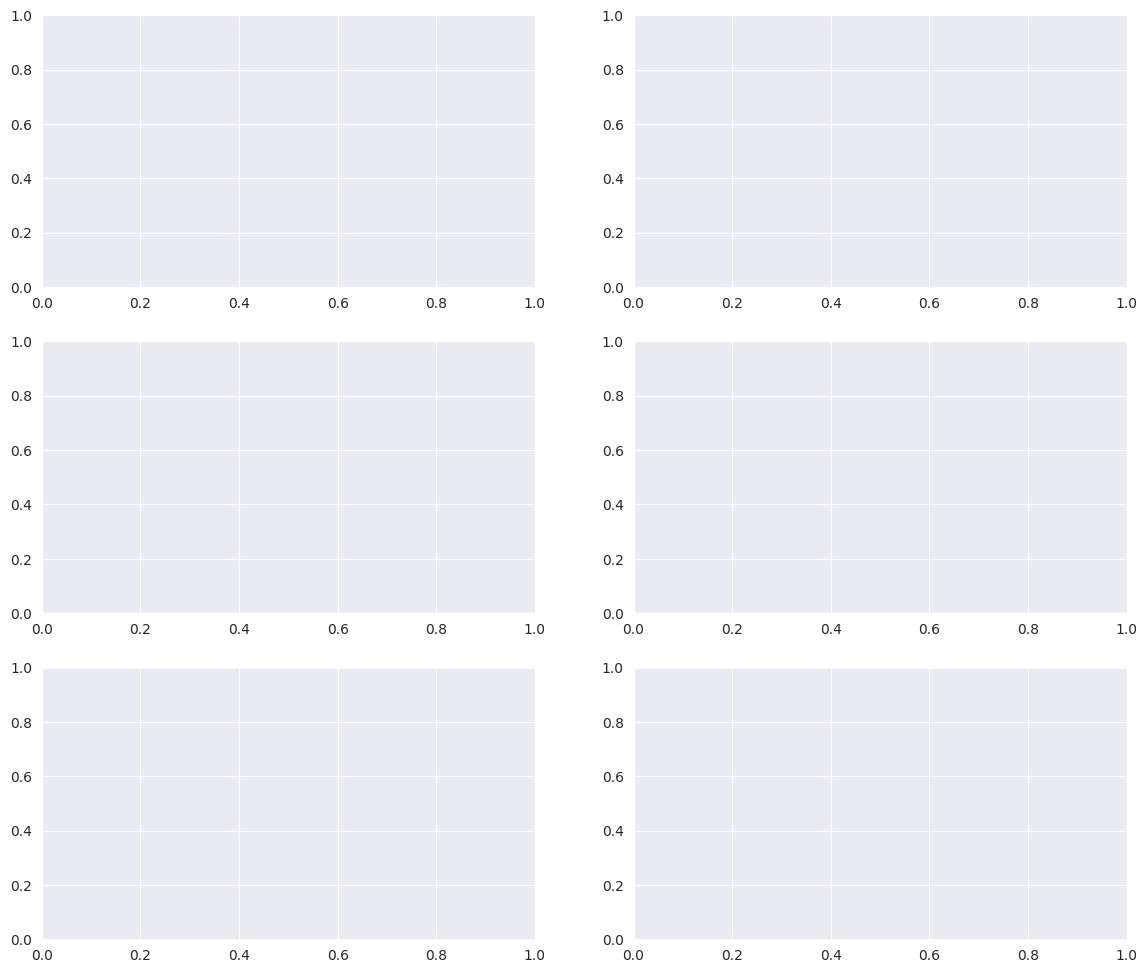

In [745]:
# Plot the distribution of Profit_Dollars, COGS, and Cost for each product
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Individuale
sns.histplot(individuale_df['Profit_Dollars'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Profit Dollars (Individuale)')
axes[0, 0].set_xlabel('Profit Dollars')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(individuale_df['COGS'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of COGS (Individuale)')
axes[1, 0].set_xlabel('COGS')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(individuale_df['cost_per_unit'], kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Cost (Individuale)')
axes[2, 0].set_xlabel('cost_per_unit')
axes[2, 0].set_ylabel('Frequency')

# Communita
sns.histplot(communita_df['Profit_Dollars'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Profit Dollars (Communita)')
axes[0, 1].set_xlabel('Profit Dollars')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(communita_df['COGS'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of COGS (Communita)')
axes[1, 1].set_xlabel('COGS')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(communita_df['cost_per_unit'], kde=True, ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Cost (Communita)')
axes[2, 1].set_xlabel('cost_per_unit')
axes[2, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Check skewness of the original data for each product
print(f"Skewness of Profit Dollars (Individuale): {individuale_df['Profit_Dollars'].skew()}")
print(f"Skewness of COGS (Individuale): {individuale_df['COGS'].skew()}")
print(f"Skewness of Cost (Individuale): {individuale_df['cost_per_unit'].skew()}")

print(f"Skewness of Profit ($) (Communita): {communita_df['Profit_Dollars'].skew()}")
print(f"Skewness of COGS (Communita): {communita_df['COGS'].skew()}")
print(f"Skewness of Cost (Communita): {communita_df['cost_per_unit'].skew()}")


In [ ]:
# Define a function to apply transformations and calculate skewness and kurtosis
def calculate_transformations_stats(df, feature):
    """
    Calculate skewness and kurtosis for different transformations of a feature, for the purpose of finding the best transformation method
    :param df: 
    :param feature: 
    :return: 
    """
    results = {}
    
    # Original
    results['Original'] = (skew(df[feature]), kurtosis(df[feature]))
    
    # Log transformation
    df['Log'] = np.log(df[feature] + 1)
    results['Log'] = (skew(df['Log']), kurtosis(df['Log']))
    
    # Box-Cox transformation
    df['BoxCox'], _ = boxcox(df[feature] + 1)
    results['BoxCox'] = (skew(df['BoxCox']), kurtosis(df['BoxCox']))
    
    # Yeo-Johnson transformation
    pt = PowerTransformer(method='yeo-johnson')
    df['YeoJohnson'] = pt.fit_transform(df[[feature]])
    results['YeoJohnson'] = (skew(df['YeoJohnson']), kurtosis(df['YeoJohnson']))
    
    # Square Root transformation
    df['Sqrt'] = np.sqrt(df[feature])
    results['Sqrt'] = (skew(df['Sqrt']), kurtosis(df['Sqrt']))
    
    # Reciprocal transformation
    df['Reciprocal'] = 1 / (df[feature] + 1)
    results['Reciprocal'] = (skew(df['Reciprocal']), kurtosis(df['Reciprocal']))
    
    # Exponential transformation
    df['Exponential'] = np.exp(df[feature])
    results['Exponential'] = (skew(df['Exponential']), kurtosis(df['Exponential']))
    
    # Robust Scaler
    scaler = RobustScaler()
    df['Robust'] = scaler.fit_transform(df[[feature]])
    results['Robust'] = (skew(df['Robust']), kurtosis(df['Robust']))
    
    # Quantile Transformation
    qt = QuantileTransformer(output_distribution='normal')
    df['Quantile'] = qt.fit_transform(df[[feature]])
    results['Quantile'] = (skew(df['Quantile']), kurtosis(df['Quantile']))
    
    # Rank Transformation
    df['Rank'] = df[feature].rank()
    results['Rank'] = (skew(df['Rank']), kurtosis(df['Rank']))
    
    # Inverse Transformation
    df['Inverse'] = 1 / (df[feature] + 1)
    results['Inverse'] = (skew(df['Inverse']), kurtosis(df['Inverse']))
    
    # Sigmoid Transformation
    df['Sigmoid'] = 1 / (1 + np.exp(-df[feature]))
    results['Sigmoid'] = (skew(df['Sigmoid']), kurtosis(df['Sigmoid']))
    
    # Z-Score Normalization
    scaler = StandardScaler()
    df['ZScore'] = scaler.fit_transform(df[[feature]])
    results['ZScore'] = (skew(df['ZScore']), kurtosis(df['ZScore']))
    
    # Min-Max Scaling
    scaler = MinMaxScaler()
    df['MinMax'] = scaler.fit_transform(df[[feature]])
    results['MinMax'] = (skew(df['MinMax']), kurtosis(df['MinMax']))
    
    # Binning
    df['Binned'] = pd.cut(df[feature], bins=10, labels=False)
    results['Binned'] = (skew(df['Binned']), kurtosis(df['Binned']))
    
    return results

In [ ]:
# Calculate and print the skewness and kurtosis for each transformation
for product_df, product_name in zip([individuale_df, communita_df], ['Individuale', 'Communita']):
    print(f"--- {product_name} ---")
    for feature in ['Profit_Dollars', 'COGS', 'cost_per_unit']:
        print(f"\nFeature: {feature}")
        stats = calculate_transformations_stats(product_df.copy(), feature)
        for transform, (skewness, kurt) in stats.items():
            print(f"{transform}: Skewness = {skewness:.4f}, Kurtosis = {kurt:.4f}")

# Insights:

## Profit_Dollars:
- The Box-Cox transformation for both products reduced skewness significantly and resulted in near-normal distributions.
- The Reciprocal and Exponential transformations increased skewness and kurtosis significantly.
- The Log and Yeo-Johnson transformations also improved the normality but to a lesser extent than Box-Cox.

## COGS:
- The Box-Cox transformation again proved effective for both products, reducing skewness and kurtosis.
- The Log transformation showed similar improvements.
- The Quantile transformation resulted in a high kurtosis value, which suggests it may not be the best choice.

## Cost:
- The Box-Cox and Yeo-Johnson transformations consistently reduced skewness and kurtosis for both products.
- The Log transformation showed improvements but not as pronounced as Box-Cox and Yeo-Johnson.
- The Exponential and Sigmoid transformations significantly increased skewness and kurtosis, indicating that these are not suitable for this feature.

## Recommendations:
- Box-Cox Transformation: This transformation consistently provided the best results across all features and products, reducing skewness and kurtosis significantly and producing distributions closer to normal. This makes it a strong candidate for further analysis.
- Yeo-Johnson Transformation: If there are concerns with the Box-Cox transformation (such as its requirement for positive values), the Yeo-Johnson transformation is a good alternative, as it also provided significant improvements.
 - Log Transformation: This transformation can be considered for features where Box-Cox or Yeo-Johnson is not applicable. It provided decent improvements in most cases.

In [ ]:
# Function to apply Box-Cox transformation and calculate statistics
def apply_boxcox_and_calculate_stats(df, features):
    """
    Apply Box-Cox transformation to the specified features and calculate skewness and kurtosis.
    :param df: 
    :param features: 
    :return: 
    """
    stats = {}
    for feature in features:
        # Apply Box-Cox transformation
        df[f'BoxCox_{feature}'], _ = boxcox(df[feature] + 1)  # Add 1 to avoid log(0)
        
        # Calculate skewness and kurtosis
        skewness = skew(df[f'BoxCox_{feature}'])
        kurt = kurtosis(df[f'BoxCox_{feature}'])
        stats[feature] = (skewness, kurt)
        
        # Print statistics
        print(f"Feature: {feature}")
        print(f"Box-Cox Transformed: Skewness = {skewness:.4f}, Kurtosis = {kurt:.4f}\n")
    
    return df, stats

In [ ]:
# Function to plot distributions
def plot_boxcox_distributions(df, features, product):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    for ax, feature in zip(axes, features):
        sns.histplot(df[f'BoxCox_{feature}'], kde=True, ax=ax)
        ax.set_title(f'Distribution of Box-Cox Transformed {feature} ({product})')
        ax.set_xlabel(f'Box-Cox {feature}')
        ax.set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [ ]:
# Features to transform
features = ['Menu_Price', 'Profit_Dollars', 'cost_per_unit']

In [ ]:
# Apply transformations and calculate statistics for each product
individuale_df, individuale_stats = apply_boxcox_and_calculate_stats(individuale_df, features)
communita_df, communita_stats = apply_boxcox_and_calculate_stats(communita_df, features)

In [ ]:
# Plot distributions for each product
print("--- Individuale ---")
plot_boxcox_distributions(individuale_df, features, 'Individuale')

print("--- Communita ---")
plot_boxcox_distributions(communita_df, features, 'Communita')

Let's analyze the results of the Box-Cox transformation:

### Individuale
#### Menu_Price
- **Skewness**: -0.0073
- **Kurtosis**: -0.0553
  - The Box-Cox transformation has effectively reduced skewness to near zero, indicating a symmetric distribution. The kurtosis is also close to zero, suggesting a distribution similar to normal.

#### Profit_Dollars
- **Skewness**: -0.0620
- **Kurtosis**: -0.6190
  - The skewness is very close to zero, indicating a symmetric distribution. The negative kurtosis suggests a slightly flatter distribution compared to a normal distribution.

#### Cost
- **Skewness**: 0.0032
- **Kurtosis**: 0.4552
  - The skewness is nearly zero, showing a symmetric distribution. The positive kurtosis indicates a distribution with heavier tails than a normal distribution.

#### COGS
- **Skewness**: 0.1094
- **Kurtosis**: -1.3264
  - The skewness is slightly positive but still close to zero, suggesting a near-symmetric distribution. The negative kurtosis indicates a distribution that is flatter than a normal distribution.

### Communita
#### Menu_Price
- **Skewness**: -0.0152
- **Kurtosis**: -0.3543
  - The skewness is very close to zero, indicating a symmetric distribution. The negative kurtosis suggests a slightly flatter distribution compared to a normal distribution.

#### Profit_Dollars
- **Skewness**: -0.0666
- **Kurtosis**: -0.4759
  - The skewness is near zero, showing a symmetric distribution. The negative kurtosis indicates a flatter distribution compared to a normal distribution.

#### Cost
- **Skewness**: -0.0040
- **Kurtosis**: 0.4497
  - The skewness is nearly zero, indicating a symmetric distribution. The positive kurtosis suggests a distribution with heavier tails than a normal distribution.

#### COGS
- **Skewness**: 0.0644
- **Kurtosis**: 1.5937
  - The skewness is slightly positive but close to zero, indicating a near-symmetric distribution. The positive kurtosis suggests a distribution with heavier tails than a normal distribution.

### Conclusion
The Box-Cox transformation has been effective in reducing skewness and adjusting kurtosis for all features, bringing them closer to a normal distribution. This is beneficial for regression-based models, which often assume normally distributed errors.

In [ ]:
individuale_df.info()

In [ ]:
communita_df.info()

In [ ]:
# List of columns to remove
columns_to_remove = ['Log_Menu_Price', 'Log_Profit_Dollars', 'Log_COGS', 'Log_Cost', 'COGS']

# Pizza count is the target variable
target = 'Pizza_Count'
communita_features = communita_df.drop(columns=[target, 'Product'] + columns_to_remove)
individuale_features = individuale_df.drop(columns=[target, 'Product'] + columns_to_remove)

In [ ]:
# Calculate the correlation matrix for Individuale
individuale_corr_matrix = individuale_features.corr().abs()
individuale_corr_matrix

In [ ]:
# Calculate the correlation matrix for Communita
communita_corr_matrix = communita_features.corr().abs()
communita_corr_matrix

## correlation analysis

In [ ]:
# Plot the correlation matrix for Individuale
plt.figure(figsize=(10, 8))
sns.heatmap(individuale_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Individuale')
plt.show()

## Correlation Matrix for Individuale:

#### Menu_Price: 
- Strong positive correlation with Profit_Percentage (0.96), Cost (0.99), BoxCox_Menu_Price (1.0), BoxCox_Profit_Dollars (0.99), and BoxCox_Cost (1.0)
- Moderate positive correlation with Pizza_Count (0.78).
- Moderate positive correlation with BoxCox_COGS (0.67).

#### Pizza_Count:
- Moderate positive correlation with Profit_Percentage (0.88), Cost (0.77), BoxCox_Profit_Dollars (0.73), BoxCox_Cost (0.79), and weak positive correlation with BoxCox_COGS (0.069).

#### Profit_Percentage:
- Strong positive correlation with Cost (0.93), BoxCox_Menu_Price (0.95), BoxCox_Profit_Dollars (0.95), and BoxCox_Cost (0.94).
- Moderate positive correlation with BoxCox_COGS (0.49).

#### Cost:
- Strong positive correlation with BoxCox_Menu_Price (1.0), BoxCox_Profit_Dollars (0.98), and BoxCox_Cost (1.0).
- Moderate positive correlation with BoxCox_COGS (0.68).

#### BoxCox_Menu_Price, BoxCox_Profit_Dollars, BoxCox_Cost:
- These have very high correlations with each other and other variables like Menu_Price and Cost.
- BoxCox_COGS shows some moderate correlations but is overall less correlated compared to others.

In [ ]:
# Plot the correlation matrix for Communita
plt.figure(figsize=(10, 8))
sns.heatmap(communita_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Communita')
plt.show()

## Correlation Matrix for Communita:

#### Menu_Price:
- Strong positive correlation with Profit_Percentage (0.96), Cost (0.99), BoxCox_Menu_Price (1.0), BoxCox_Profit_Dollars (1.0), and BoxCox_Cost (0.99).
- Moderate positive correlation with Pizza_Count (0.83).
- Strong positive correlation with BoxCox_COGS (0.96).

#### Pizza_Count:
- Moderate positive correlation with Profit_Percentage (0.71), Cost (0.85), BoxCox_Profit_Dollars (0.81), BoxCox_Cost (0.84), and BoxCox_COGS (0.7).

#### Profit_Percentage:
- Strong positive correlation with Cost (0.91), BoxCox_Menu_Price (0.96), BoxCox_Profit_Dollars (0.96), and BoxCox_Cost (0.93).
- Strong positive correlation with BoxCox_COGS (0.91).

#### Cost:
- Strong positive correlation with BoxCox_Menu_Price (0.99), BoxCox_Profit_Dollars (0.98), and BoxCox_Cost (0.99).
- Strong positive correlation with BoxCox_COGS (0.97).

#### BoxCox_Menu_Price, BoxCox_Profit_Dollars, BoxCox_Cost:
- These have very high correlations with each other and other variables like Menu_Price and Cost.
- BoxCox_COGS shows strong correlations with all other variables.

## Insights:
- High Correlations: The variables Menu_Price, Cost, BoxCox_Menu_Price, BoxCox_Profit_Dollars, and BoxCox_Cost are highly correlated with each other in both products. This redundancy indicates that many of these variables are essentially conveying the same information.
- Moderate Correlations: Pizza_Count shows moderate correlations with several other variables but does not exhibit extreme values.
- Remaining Variables: BoxCox_COGS shows moderate correlations but might be retained for analysis due to its lower correlation values compared to the other BoxCox-transformed features.

## Next Steps:
- Further Feature Reduction: Based on the correlation analysis, we may consider further reducing the features by keeping only the most representative features and removing the highly redundant ones.
- Dimensionality Reduction Techniques: Techniques like PCA (Principal Component Analysis) can be used to reduce the feature set while preserving the variance in the data.
- Model Building: Proceed with model building using the reduced feature set to evaluate the performance and make adjustments accordingly.

# Feature Selection
Since many features are highly correlated, consider feature selection techniques to avoid multicollinearity in regression models.

In [ ]:
# Combine both datasets
combined_df = pd.concat([individuale_df, communita_df])

# Remove non-numeric columns
numeric_df = combined_df.select_dtypes(include=[np.number])

In [ ]:
# Calculate the correlation matrix
corr_matrix = numeric_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Use a higher threshold, e.g., 0.95 instead of 0.98
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
numeric_df_reduced = numeric_df.drop(columns=to_drop)

print(f"Features to drop (correlation > 0.95): {to_drop}")
print(f"Remaining features: {numeric_df_reduced.columns}")

Step 2: Variance Inflation Factor (VIF)

In [ ]:
# Function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Calculate VIF values
vif_data = calculate_vif(numeric_df_reduced)

# Filter out features with VIF > 10 instead of 5
to_drop_vif = vif_data[vif_data['VIF'] > 10]['feature']
numeric_df_reduced_vif = numeric_df_reduced.drop(columns=to_drop_vif)

print(f"Features to drop due to high VIF (>10): {to_drop_vif}")
print(f"Remaining features after VIF filtering: {numeric_df_reduced_vif.columns}")


Step 3: Recursive Feature Elimination (RFE)

In [ ]:
# Ensure the target variable is not part of the features
X = numeric_df_reduced_vif.drop(columns=['Profit_Dollars'])
y = numeric_df['Profit_Dollars']  # Ensuring we use the original dataset for the target variable

# Initialize the model
model = LinearRegression()

# Initialize RFE with the model, keeping a higher number of features
rfe = RFE(estimator=model, n_features_to_select=3)

# Fit RFE
rfe.fit(X, y)

# Get the ranking of features
ranking = rfe.ranking_
features = X.columns

# Get the selected features
selected_features = features[ranking == 1]

print(f"Selected features: {selected_features}")

## Profit analysis

In [ ]:
# Calculate total profit for each product
df['Total_Profit'] = df['Pizza_Count'] * (df['Profit_Percentage'] / 100) * df['Menu_Price']

# Group by product and calculate total profit
total_profit = df.groupby('Product')['Total_Profit'].sum()

# Display the total profit for each product
print(total_profit)

# Bar plot for total profit
total_profit.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])
plt.title('Total Profit by Product')
plt.xlabel('Product')
plt.ylabel('Total Profit')
plt.show()